In [214]:
import pandas as pd

In [215]:
df_final=pd.read_csv('df_final.csv')

In [216]:
df_final = df_final.drop(columns=['reggaeton', 'rock'])

In [217]:
df_final['Genero']

0              italian hip hop, italian pop, trap italiana
1                                                      NaN
2        ambient, braindance, electronica, intelligent ...
3                           jam band, neo mellow, pop rock
4                        argentine hip hop, trap argentino
                               ...                        
16861                                        j-pop, j-rock
16862                                                k-pop
16863                                    k-pop, korean r&b
16864                              k-pop, k-pop girl group
16865                                    k-pop, korean r&b
Name: Genero, Length: 16866, dtype: object

In [218]:
df_final['Stream'].describe()

count    1.686600e+04
mean     1.362465e+08
std      2.433885e+08
min      6.574000e+03
25%      1.748466e+07
50%      4.993142e+07
75%      1.391041e+08
max      3.386520e+09
Name: Stream, dtype: float64

In [219]:
df_final.columns

Index(['Acousticness', 'Album', 'Album_type', 'Artist', 'Danceability', 'Date',
       'Duration_ms', 'Energy', 'Instrumentalness', 'Key', 'Licensed', 'Likes',
       'Liveness', 'Loudness', 'Speechiness', 'Stream', 'Tempo', 'Title',
       'Track', 'Valence', 'Views', 'official_video', 'Year', 'Decada',
       'Genero', 'Duration_min', 'Genero_filtrado', 'Cluster'],
      dtype='object')

In [221]:
df_generos = df_final.assign(Genero=df_final['Genero'].str.split(', ')).explode('Genero')



In [222]:
# Agrupar por 'Genero' y contar el número de tracks
df_generos_count = df_generos.groupby('Genero', as_index=False).size()

# Renombrar las columnas para mayor claridad
df_generos_count.columns = ['Genero', 'Num_Tracks']

# Ordenar por número de tracks en orden descendente
df_generos_count = df_generos_count.sort_values(by='Num_Tracks', ascending=False)

# Reiniciar el índice para un formato limpio
df_generos_count.reset_index(drop=True, inplace=True)

# Mostrar el DataFrame
print(df_generos_count)



                           Genero  Num_Tracks
0                            rock        1565
1                             pop        1549
2                             rap        1184
3                       dance pop         887
4                         hip hop         816
...                           ...         ...
1107          neue deutsche harte           3
1108                uk doom metal           2
1109  australian children's music           2
1110                   afghan pop           2
1111                rock keyboard           1

[1112 rows x 2 columns]


In [223]:
df_generos_count.head(20)

,Genero,Num_Tracks
0,rock,1565
1,pop,1549
2,rap,1184
3,dance pop,887
4,hip hop,816
5,latin pop,777
6,classic rock,773
7,filmi,684
8,soft rock,683
9,album rock,650


In [224]:
df_final['Genero'] = df_final['Genero'].apply(
    lambda x: [genero.strip() for genero in x.split(',')]  # Elimina espacios
    if isinstance(x, str) 
    else []  # Maneja NaN u otros tipos (asignando lista vacía)
)

In [225]:
df_final['Genero']

0            [italian hip hop, italian pop, trap italiana]
1                                                       []
2        [ambient, braindance, electronica, intelligent...
3                         [jam band, neo mellow, pop rock]
4                      [argentine hip hop, trap argentino]
                               ...                        
16861                                      [j-pop, j-rock]
16862                                              [k-pop]
16863                                  [k-pop, korean r&b]
16864                            [k-pop, k-pop girl group]
16865                                  [k-pop, korean r&b]
Name: Genero, Length: 16866, dtype: object

In [226]:
def busca_genero(genero_buscado, lista_generos):
    # Si el valor es NaN (tipo float), retornar 0
    if isinstance(lista_generos, float):
        return 0
    # Si es una lista o cadena, verificar el género
    if genero_buscado in lista_generos:
        return 1
    else:
        return 0

In [272]:
df_final['rock'] = df_final['Genero'].apply(lambda x: busca_genero('reggaeton', x))


In [273]:
df_final['rock'].sum()

np.int64(512)

In [274]:
df_gen=df_final[df_final['rock'] ==1]

## Cálculo de quartiles del Stream

In [275]:
import pandas as pd

# Calcular los cuartiles
q1 = df_gen['Stream'].quantile(0.25)  # Primer cuartil (Q1)
q2 = df_gen['Stream'].quantile(0.50)  # Segundo cuartil (Q2) - Mediana
q3 = df_gen['Stream'].quantile(0.75)  # Tercer cuartil (Q3)

print(f"Q1: {q1}, Q2 (Mediana): {q2}, Q3: {q3}")


Q1: 30138603.25, Q2 (Mediana): 105305287.0, Q3: 289942745.0


Voy a dividir en dos categorias de stream. Una moderadamente extoso Stream menor a q3 y otra exitoso mayor a q3

In [276]:
# Definir los límites manualmente
bins = [0, q3, df_gen['Stream'].max()]
labels = [0,1]

df_gen['Categoria'] = pd.cut(df_gen['Stream'], bins=bins, labels=labels, include_lowest=True)
# Ver la distribución de las categorías
print(df_gen['Categoria'].value_counts())

Categoria
0    384
1    128
Name: count, dtype: int64


La categorías estan algo desbalanceadas, para entrenar el modelo se va acotar el df de prueba. Solo se van a usar 4217 valores de la categoría cero

In [277]:
count_cat1=df_gen['Categoria'].value_counts()[1]

In [278]:
# Filtrar las categorías
categoria_0 = df_gen[df_gen['Categoria'] == 0]
categoria_1 = df_gen[df_gen['Categoria'] == 1]

# Muestrear 175 registros aleatorios de la categoría 0
categoria_0_sample = categoria_0.sample(n=count_cat1, random_state=42)

# Combinar los 175 registros de cada categoría
df_balanceado = pd.concat([categoria_0_sample, categoria_1])

# Barajar las filas (opcional, para mezclar las categorías)
df_balanceado = df_balanceado.sample(frac=1, random_state=42).reset_index(drop=True)

# Verificar la distribución de las categorías
print(df_balanceado['Categoria'].value_counts())

Categoria
0    128
1    128
Name: count, dtype: int64


In [279]:
X=df_balanceado[['Acousticness','Danceability', 'Duration_min', 'Energy',
       'Instrumentalness', 'Key', 'Liveness', 'Loudness',
       'Speechiness', 'Tempo', 'Valence',
        ]]

In [280]:
y=df_balanceado['Categoria']

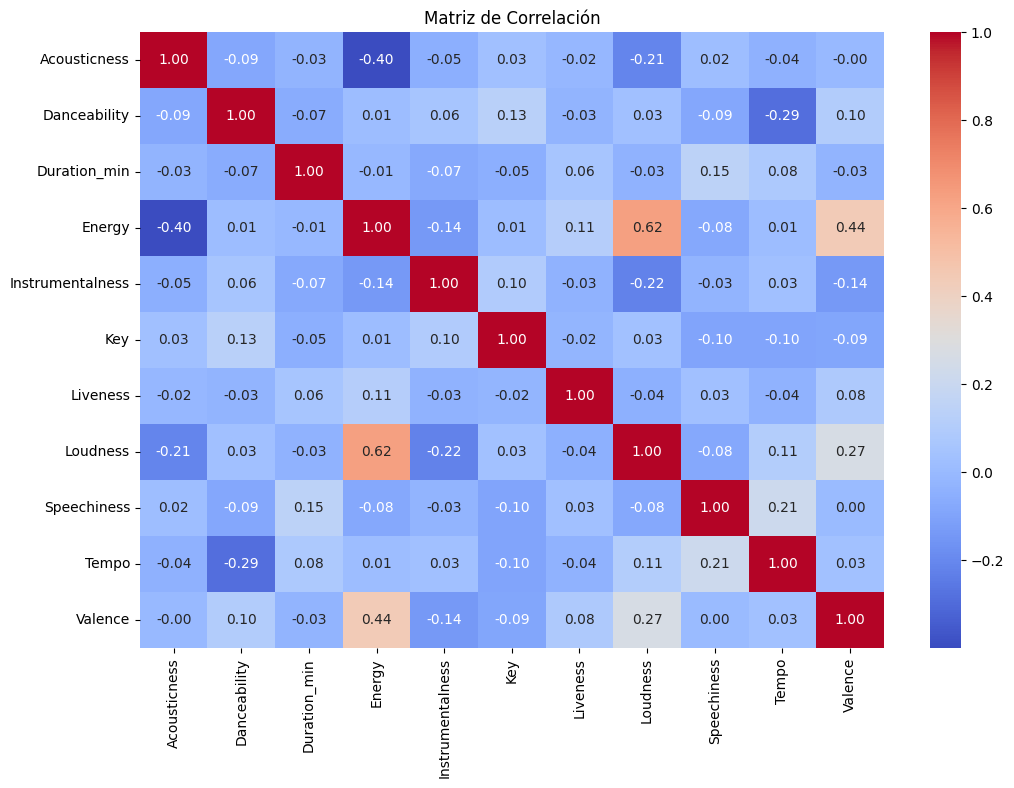

In [281]:
import seaborn as sns
import matplotlib.pyplot as plt

# Matriz de correlación
corr_matrix = X.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de Correlación")
plt.show()

In [282]:
from sklearn.feature_selection import SelectKBest, f_classif

# Selecciona las 5 mejores características
selector = SelectKBest(score_func=f_classif, k=5)
X_new = selector.fit_transform(X, y)

# Nombres de las características seleccionadas
selected_features = X.columns[selector.get_support()]
print("Características seleccionadas:", selected_features)

Características seleccionadas: Index(['Acousticness', 'Duration_min', 'Instrumentalness', 'Loudness',
       'Speechiness'],
      dtype='object')


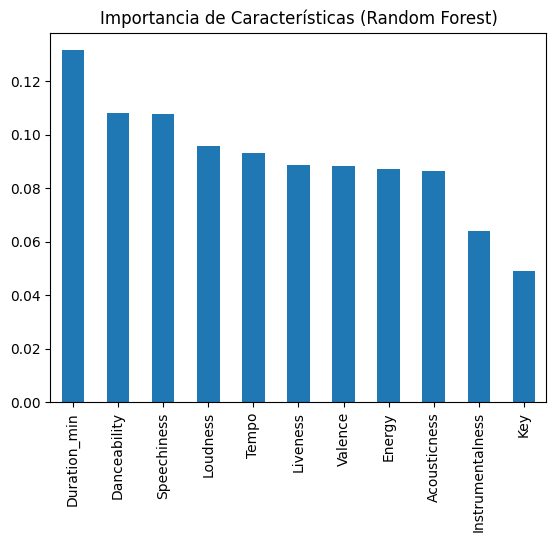

In [283]:
from sklearn.ensemble import RandomForestClassifier

# Entrenar modelo para obtener importancia de características
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X, y)

# Importancia
importances = pd.Series(model.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).plot(kind='bar')
plt.title("Importancia de Características (Random Forest)")
plt.show()

In [284]:
from sklearn.model_selection import train_test_split, cross_val_score
# 🔹 2. Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [285]:
from lazypredict.Supervised import LazyClassifier

In [286]:
lazy_clf= LazyClassifier(verbose=0,
					ignore_warnings=False,
					custom_metric=None)

# fitting data in LazyClassifier
models, predictions = lazy_clf.fit(X_train, X_test,
							y_train, y_test)
models

 28%|██▊       | 9/32 [00:00<00:00, 32.22it/s]

CategoricalNB model failed to execute
Negative values in data passed to CategoricalNB (input X).
FixedThresholdClassifier model failed to execute
FixedThresholdClassifier.__init__() missing 1 required positional argument: 'estimator'


100%|██████████| 32/32 [00:00<00:00, 37.07it/s]

SelfTrainingClassifier model failed to execute
You must pass an estimator to SelfTrainingClassifier. Use `estimator`.
StackingClassifier model failed to execute
StackingClassifier.__init__() missing 1 required positional argument: 'estimators'
TunedThresholdClassifierCV model failed to execute
TunedThresholdClassifierCV.__init__() missing 1 required positional argument: 'estimator'
XGBClassifier model failed to execute
'super' object has no attribute '__sklearn_tags__'
[LightGBM] [Info] Number of positive: 105, number of negative: 99
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000038 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 646
[LightGBM] [Info] Number of data points in the train set: 204, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.514706 -> initscore=0.058841
[LightGBM] [Info] Start training from score 0.058841
[LightGBM] [Warning] No further splits wit

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
AdaBoostClassifier,0.63,0.64,0.64,0.64,0.08
DecisionTreeClassifier,0.60,0.58,0.58,0.59,0.01
LGBMClassifier,0.58,0.57,0.57,0.58,0.02
SVC,0.56,0.57,0.57,0.56,0.01
PassiveAggressiveClassifier,0.58,0.56,0.56,0.57,0.01
NearestCentroid,0.56,0.56,0.56,0.56,0.01
RandomForestClassifier,0.56,0.55,0.55,0.56,0.14
BaggingClassifier,0.56,0.55,0.55,0.56,0.03
QuadraticDiscriminantAnalysis,0.50,0.54,0.54,0.43,0.01


In [289]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Espacio de búsqueda
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'learning_rate': [0.001, 0.01, 0.1, 0.5, 1.0],
    'base_estimator': [DecisionTreeClassifier(max_depth=1), DecisionTreeClassifier(max_depth=2)]
}

# Configurar GridSearchCV
grid_search = GridSearchCV(
    AdaBoostClassifier(),
    param_grid,
    scoring='f1_weighted',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Ajustar el modelo
grid_search.fit(X_train, y_train)

# Mostrar los mejores hiperparámetros
print("Mejores parámetros:", grid_search.best_params_)

# Evaluar el mejor modelo
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

from sklearn.metrics import classification_report
print("Reporte de clasificación con AdaBoost optimizado:")
print(classification_report(y_test, y_pred))


Fitting 5 folds for each of 40 candidates, totalling 200 fits


ValueError: Invalid parameter 'base_estimator' for estimator AdaBoostClassifier(). Valid parameters are: ['algorithm', 'estimator', 'learning_rate', 'n_estimators', 'random_state'].

In [288]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.001, 0.01, 0.1, 0.5],
    'base_estimator': [None, DecisionTreeClassifier(max_depth=1), DecisionTreeClassifier(max_depth=2)]
}

grid = GridSearchCV(AdaBoostClassifier(), params, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train, y_train)

print(f"Mejor accuracy: {grid.best_score_:.2f}")
print(f"Mejores parámetros: {grid.best_params_}")

NameError: name 'DecisionTreeClassifier' is not defined

In [258]:
# Ejemplo para SVC con búsqueda aleatoria
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC

params_svc = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto', 0.1, 0.01],
    'kernel': ['rbf', 'poly']
}

search_svc = RandomizedSearchCV(SVC(), params_svc, n_iter=20, cv=5, scoring='accuracy', n_jobs=-1)
search_svc.fit(X_train, y_train)

KeyboardInterrupt: 

In [256]:
decadas=[1970,1980,1990,2000,2010,2020]

In [257]:
for decada in decadas:

        df_decada=df_final[df_final['Decada']==decada]
        #df_decada.info()
        ## Cálculo de quartiles del Stream
        

        # Calcular los cuartiles
        q1 = df_decada['Stream'].quantile(0.25)  # Primer cuartil (Q1)
        q2 = df_decada['Stream'].quantile(0.50)  # Segundo cuartil (Q2) - Mediana
        q3 = df_decada['Stream'].quantile(0.75)  # Tercer cuartil (Q3)

        #print(f"Q1: {q1}, Q2 (Mediana): {q2}, Q3: {q3}")

        #Voy a dividir en dos categorias de stream. Una moderadamente extoso Stream menor a q3 y otra exitoso mayor a q3
        # Definir los límites manualmente
        bins = [0, q3, df_decada['Stream'].max()]
        labels = [0,1]

        df_decada['Categoria'] = pd.cut(df_decada['Stream'], bins=bins, labels=labels, include_lowest=True)
        # Ver la distribución de las categorías
        
        
        count_cat1=df_decada['Categoria'].value_counts()[1]
        # Filtrar las categorías
        categoria_0 = df_decada[df_decada['Categoria'] == 0]
        categoria_1 = df_decada[df_decada['Categoria'] == 1]

        
        categoria_0_sample = categoria_0.sample(n=count_cat1, random_state=42)

        
        df_balanceado = pd.concat([categoria_0_sample, categoria_1])

        # Barajar las filas (opcional, para mezclar las categorías)
        df_balanceado = df_balanceado.sample(frac=1, random_state=42).reset_index(drop=True)

        # Verificar la distribución de las categorías
        #print(f'valores por decada {decada}')
        #print(df_balanceado['Categoria'].value_counts())
        
        X=df_balanceado[['Acousticness','Danceability', 'Duration_min', 'Energy',
        'Instrumentalness', 'Key', 'Liveness', 'Loudness',
        'Speechiness', 'Tempo', 'Valence',
                ]]
        y=df_balanceado['Categoria']
        from sklearn.model_selection import train_test_split, cross_val_score
        # 🔹 2. Dividir los datos en entrenamiento y prueba
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        
        
        

        # Crear el modelo con los mejores parámetros
        rf_optimized = RandomForestClassifier(
        class_weight=None, 
        max_depth=5, 
        max_features='sqrt', 
        min_samples_leaf=1, 
        min_samples_split=10, 
        n_estimators=200, 
        random_state=42
        )

        # Entrenar el modelo con los datos de entrenamiento
        rf_optimized.fit(X_train, y_train)

        # Predecir las clases en el conjunto de prueba
        y_pred = rf_optimized.predict(X_test)

        # Reporte de clasificación
        print(f"Reporte de Clasificación para Random Forest Optimizado década {decada}:")
        print(classification_report(y_test, y_pred))

        # Matriz de confusión
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title("Matriz de Confusión para Random Forest Optimizado década {decada}")
        plt.xlabel("Predicción")
        plt.ylabel("Verdadero")
        plt.show()
        

NameError: name 'RandomForestClassifier' is not defined